In [1]:
#naive forecaster

In [10]:
import pandas as pd
import numpy as np

In [11]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [28]:
uber = pd.read_csv('../uber_data.csv', parse_dates= True, index_col=0)
uber

,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
pickup_dt,,,,,,,,,,,,
2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-30 23:00:00,EWR,0,7.0,10.0,75.0,65.0,1011.8,0.0,0.0,0.0,0.0,N
2015-06-30 23:00:00,Manhattan,3828,7.0,10.0,75.0,65.0,1011.8,0.0,0.0,0.0,0.0,N
2015-06-30 23:00:00,Queens,580,7.0,10.0,75.0,65.0,1011.8,0.0,0.0,0.0,0.0,N


In [29]:
man = uber[uber['borough'] == 'Staten Island'].drop('borough', axis=1)
man

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
pickup_dt,,,,,,,,,,,
2015-01-01 01:00:00,6,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2015-01-01 02:00:00,7,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,Y
2015-01-01 03:00:00,12,5.0,10.0,30.0,8.0,1022.3,0.0,0.0,0.0,0.0,Y
2015-01-01 04:00:00,5,5.0,10.0,29.0,9.0,1022.0,0.0,0.0,0.0,0.0,Y
2015-01-01 05:00:00,3,5.0,10.0,28.0,9.0,1021.8,0.0,0.0,0.0,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-30 19:00:00,3,5.0,10.0,80.0,58.0,1012.5,0.0,0.0,0.0,0.0,N
2015-06-30 20:00:00,3,8.0,10.0,80.0,58.0,1012.4,0.0,0.0,0.0,0.0,N
2015-06-30 21:00:00,2,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,N


In [30]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd2f7af30d0>)

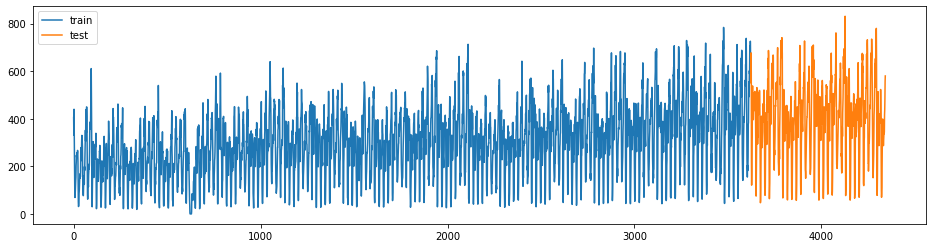

In [23]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting.forecasting import plot_ys

man = man.reset_index(drop = True)

train, test = temporal_train_test_split(man, test_size=720)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']

X_test = test.drop('pickups', axis=1)
y_test = test['pickups']

plot_ys(y_train,y_test, labels=['train','test'])

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd2fa076610>)

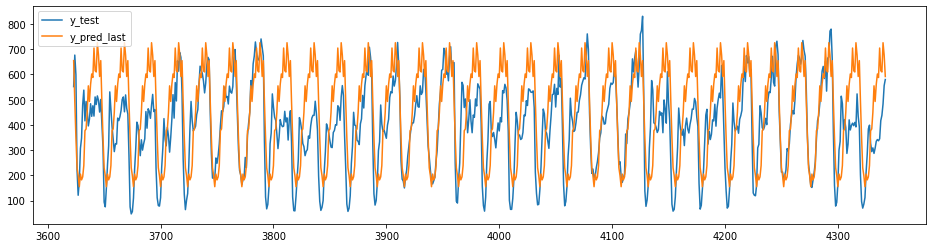

In [24]:
from sktime.forecasting.naive import NaiveForecaster

fh = np.arange(1,len(y_test)+1)

naive_forecaster_last = NaiveForecaster(strategy= "last", sp=24)
naive_forecaster_last.fit(y_train)
y_last = naive_forecaster_last.predict(fh)


plot_ys(y_test,y_last,labels=['y_test','y_pred_last'])



In [25]:
type(y_last)

pandas.core.series.Series

In [26]:
from sktime.performance_metrics.forecasting import smape_loss
smape_loss(y_last,y_test)

0.3190007362374496

In [55]:
a = np.array(a)
a

array([4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5, 2, 3, 2, 2, 2, 5, 2, 6, 1,
       2, 1, 4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5, 2, 3, 2, 2, 2, 5, 2,
       6, 1, 2, 1, 4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5, 2, 3, 2, 2, 2,
       5, 2, 6, 1, 2, 1, 4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5, 2, 3, 2,
       2, 2, 5, 2, 6, 1, 2, 1, 4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5, 2,
       3, 2, 2, 2, 5, 2, 6, 1, 2, 1, 4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2,
       5, 2, 3, 2, 2, 2, 5, 2, 6, 1, 2, 1, 4, 5, 2, 1, 3, 1, 1, 0, 2, 2,
       4, 2, 5, 2, 3, 2, 2, 2, 5, 2, 6, 1, 2, 1, 4, 5, 2, 1, 3, 1, 1, 0,
       2, 2, 4, 2, 5, 2, 3, 2, 2, 2, 5, 2, 6, 1, 2, 1, 4, 5, 2, 1, 3, 1,
       1, 0, 2, 2, 4, 2, 5, 2, 3, 2, 2, 2, 5, 2, 6, 1, 2, 1, 4, 5, 2, 1,
       3, 1, 1, 0, 2, 2, 4, 2, 5, 2, 3, 2, 2, 2, 5, 2, 6, 1, 2, 1, 4, 5,
       2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5, 2, 3, 2, 2, 2, 5, 2, 6, 1, 2, 1,
       4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5, 2, 3, 2, 2, 2, 5, 2, 6, 1,
       2, 1, 4, 5, 2, 1, 3, 1, 1, 0, 2, 2, 4, 2, 5,

In [27]:
y_last.to_csv('pred_naive_queens.csv')

In [59]:
a = pd.read_csv('pred_naive_queens.csv')
#a = np.array(a['0'])
a

,Unnamed: 0,0
0,3623,655
1,3624,493
2,3625,350
3,3626,230
4,3627,199
...,...,...
715,4338,615
716,4339,610
717,4340,726
718,4341,677


In [26]:
import pickle

#pickle.dump(naive_forecaster_last, open('model_naive.pkl','wb'))



0.5156492945716101

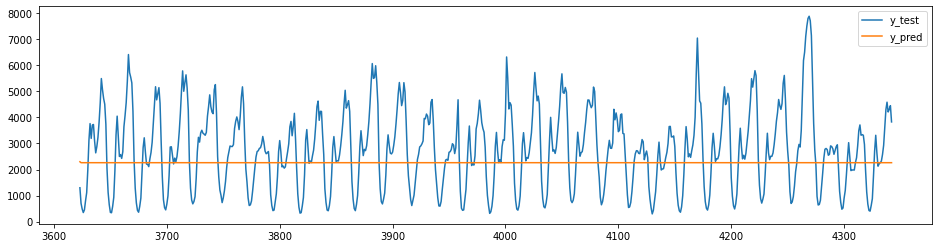

In [40]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.ensemble import RandomForestRegressor

params = {
    'criterion':'mae',
    'max_depth':2,
    'verbose':0
}

regressor = RandomForestRegressor(**params)
forecaster = ReducedRegressionForecaster(regressor,window_length=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_ys(y_test, y_pred, labels=['y_test', 'y_pred'])
smape_loss(y_test, y_pred)

In [41]:
smape_perso(y_test,y_pred)

51.56492945716095

In [ ]:

# le model de random forest est moins bon que le naive ca sert à rien en l'état de le sauvegarder et de l'utiliser
#pickle.dump(forecaster, open('model_randomforest.pkl','wb'))


In [42]:
X_test

,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
3623,2.50,3.4,69.00,66.50,1017.2,0.045,1.21,0.0,0.0,N
3624,6.25,3.5,68.75,66.25,1018.0,0.080,0.00,0.0,0.0,N
3625,8.00,9.1,65.00,62.00,1018.7,0.060,0.00,0.0,0.0,N
3626,8.00,9.1,63.00,59.00,1019.9,0.010,0.00,0.0,0.0,N
3627,9.00,10.0,59.00,56.00,1020.2,0.060,0.00,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...,...
4338,5.00,10.0,80.00,58.00,1012.5,0.000,0.00,0.0,0.0,N
4339,8.00,10.0,80.00,58.00,1012.4,0.000,0.00,0.0,0.0,N
4340,7.00,10.0,76.00,61.00,1012.4,0.000,0.00,0.0,0.0,N
4341,5.00,10.0,76.00,64.00,1011.9,0.000,0.00,0.0,0.0,N


In [43]:
y_test

3623    1301
3624     704
3625     488
3626     349
3627     453
        ... 
4338    4585
4339    4210
4340    4313
4341    4452
4342    3828
Name: pickups, Length: 720, dtype: int64

In [46]:
X_test.to_csv('../X_test_naive.csv', index=False)
y_test.to_csv('../y_test_naive.csv', index=False)

In [47]:
a = pd.read_csv('../y_test_naive.csv')
a

,pickups
0,1301
1,704
2,488
3,349
4,453
...,...
715,4585
716,4210
717,4313
718,4452
